In [5]:
import itertools
import random

%matplotlib inline
import networkx as nx

# Complex Data Analysis 2023-2024

### Andreia Sofia Teixeira

## TP Network Science Fundamentals - Part 3

Contents:
1. [Python's random module](#1.-Python's-random-module)
2. [Random network model](#2.-Random-Network-Model)
3. [Small-World model](#3.-Small-World-Model)
4. [Preferential attachment model](#4.-Preferential-Attachment-Model)

For each of the models presented in this tutorial, we present the algorithm, an example implementation, and the corresponding NetworkX code function to generate the model. The implementations provided in this tutorial are written for clarity, not for efficiency; it's best to use the NetworkX functions when doing real analysis work.

#### Based on the tutorial of Chapter 5 of the book *A First Course on Network Science*

# Python's `random` module

Many network models rely on randomness in their generative algorithms. Python's [random module](https://docs.python.org/3.7/library/random.html) provides four key functions of use when coding network models.

### `random.random`

Often in an algorithm, we need something to happen with some probability $p$. The canonical way to decide whether or not such an event happens is to generate a random number $r$ between 0 and 1, and if $r < p$, then the event occurs. The [random.random()](https://docs.python.org/3.7/library/random.html#random.random) function returns just such a random number in the interval [0, 1).

For a simple example, consider an unfair coin that comes up heads 75% of the time. We can write the following code to flip such a coin 10 times, reporting the outcome each time:

In [4]:
p = 0.75

# Do this 10 times
for _ in range(10):
    r = random.random()
    if r < p:
        print('Heads')
    else:
        print('Tails')

Heads
Heads
Heads
Tails
Heads
Heads
Tails
Heads
Tails
Heads


As we would expect from a random process, executing the previous cell again will generate a different sequence of flips -- each one is independently generated.

###  `random.choice`

When we have a population of discrete choices and we need to select one at random, we use [random.choice()](https://docs.python.org/3.7/library/random.html#random.choice). For example, instead of "[eeny, meeny, miny, moe](https://en.wikipedia.org/wiki/Eeny,_meeny,_miny,_moe)," we can use random.choice to choose a random name:

In [5]:
names = ['Alice', 'Bob', 'Cathy', 'Dan']
random.choice(names)

'Bob'

### `random.sample`

If we have a collection and we need to select more than one element without replacement, we use [random.sample()](https://docs.python.org/3.7/library/random.html#random.sample). For example, to choose two nodes at random from the nodes in a graph, we can use the following:

In [9]:
G = nx.cycle_graph(5)
random.sample(list(G.nodes), 2)

[3, 4]

### `random.choices`

We use [random.choices()](https://docs.python.org/3.7/library/random.html#random.choices) when we need to choose an element from a collection when the chances of selecting each element are not identical.

For an example, let's assume Alice, Bob, and Carol are in a raffle drawing. Alice bought one ticket, Bob bought three tickets, and Carol bought four tickets. We can simulate ten different draws of this raffle, replacing the drawn ticket each time, with the following code:

In [11]:
names = ['Alice', 'Bob', 'Carol']
tickets = [1, 3, 4]

for _ in range(10):
    print(random.choices(names, tickets))

['Bob']
['Bob']
['Alice']
['Bob']
['Carol']
['Carol']
['Carol']
['Carol']
['Alice']
['Bob']


Running the above cell should give what we expect: Carol wins the drawing most often, with Bob winning some times, and Alice winning occasionally. Of course this outcome depends on the luck of the draw!

By specifying the keyword argument `k=`, we can choose *k* items from the collection *with replacement*:

In [12]:
random.choices(names, tickets, k=10)

['Bob',
 'Carol',
 'Carol',
 'Carol',
 'Carol',
 'Carol',
 'Carol',
 'Bob',
 'Bob',
 'Alice']

The weights provided to `random.choices` do not have to be integers -- any numeric weights are fine.

# Random Network Model

The random network model, as formulated by Gilbert, has two parameters: the number of nodes $N$, and the link probability $p$. As in the book text, the algorithm for creating this network is as follows:

1. Select a pair of nodes, say i and j.
2. Generate a random number r between 0 and 1. If r < p, then add a link between i and j.
3. Repeat (1) and (2) for all pairs of nodes.

We'll need a couple of tools from Python for this task:

### Generating combinations

We've previously looped over all nodes in a graph, as well as all graph edges, but this algorithm requires us to loop over all *pairs* of nodes, *i.e.* all possible edges. The `itertools` module in Python's standard library gives us the [combinations()](https://docs.python.org/3.7/library/itertools.html#itertools.combinations) function, an elegant way to loop over pairs of elements in a sequence:

In [13]:
elements = [0, 1, 2, 3, 4]
list(itertools.combinations(elements, 2))

[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (1, 2),
 (1, 3),
 (1, 4),
 (2, 3),
 (2, 4),
 (3, 4)]

The second argument to `itertools.combinations()` is the length of the sequences we want in the output. Since we want pairs, we'll specify 2. Note the nice properties of the output:

1. No repeat elements -- we don't want to consider self-loops like `('a', 'a')`.
2. Pairs are in sorted order -- `('a', 'b')` and `('b', 'a')` are the same edge in an undirected graph.

We can thus use this to loop over all pairs of nodes in a graph:

In [14]:
G = nx.Graph()
G.add_nodes_from(elements)

list(itertools.combinations(G.nodes, 2))

[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (1, 2),
 (1, 3),
 (1, 4),
 (2, 3),
 (2, 4),
 (3, 4)]

### Gilbert random graph model

With these tools in our toolbelt, we can code the algorithm for the Gilbert random graph model.

In [15]:
def gnp_random_graph(N, p):
    G = nx.Graph()
    G.add_nodes_from(range(N))
    
    for i, j in itertools.combinations(G.nodes, 2):
        r = random.random()
        if r < p:
            G.add_edge(i, j)
        # Do nothing if r >= p
        
    return G

We can use this function to generate a graph. Since this is a random graph, each execution of the following code will generate a different graph. 

Graph has 24 edges.


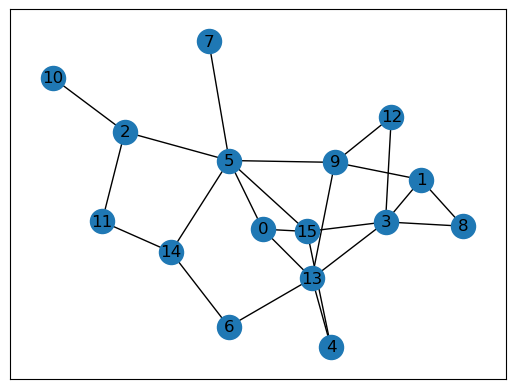

In [20]:
G = gnp_random_graph(16, 0.15)
nx.draw_networkx(G)
print('Graph has', G.number_of_edges(), 'edges.')

Run the above cell a few times and note that the number of edges varies slightly among random graphs generated with the same parameters. This is because each pair of nodes has an independent chance of being an edge.

### Erdös-Rényi random graph model

Instead of specifying the link probability $p$, we can also generate a graph of $N$ nodes with exactly $M$ edges by using `random.sample()` to choose M of the possible edges generated with `itertools.combinations()`:

In [21]:
def gnm_random_graph(N, M):
    G = nx.Graph()
    G.add_nodes_from(range(N))
    
    possible_edges = itertools.combinations(G.nodes, 2)
    edges_to_add = random.sample(list(possible_edges), M)
    G.add_edges_from(edges_to_add)
    
    return G

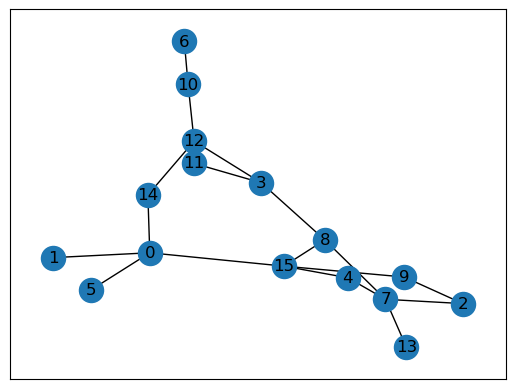

In [22]:
G = gnm_random_graph(16, 18)
nx.draw_networkx(G)

### NetworkX functions

NetworkX has a function for the $G_{n,p}$ random graph specifying number of nodes $N$ and link probability $p$:  [gnp_random_graph()](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.random_graphs.gnp_random_graph.html).

In addition, NetworkX provides [gnm_random_graph()](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.random_graphs.gnm_random_graph.html), which generates a $G_{n,m}$ graph, where we specify the number of nodes $N$ and the desired number of edges $M$.

# Small-World Model

The algorithm for generating a small-world network is as such:

1. Begin with a ring of $N$ nodes
2. Connect each node to its $k$ nearest neighbors (or $k-1$ if k is odd).
3. For each edge $(u, v)$, with probability $p$, replace edge $(u, v)$ with $(u, w)$ where $w$ is not a neighbor of $u$.

We'll do these step-by-step first, and combine them into a function last.

### Create a ring of N nodes

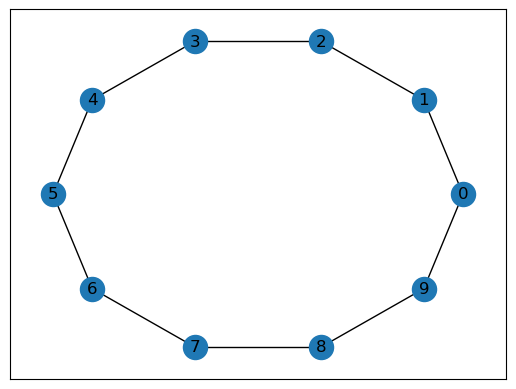

In [23]:
N = 10
G = nx.cycle_graph(N)
nx.draw_networkx(G, with_labels=True, pos=nx.circular_layout(G))

### Connect each node to its $k$ nearest neighbors

We'll use modular arithmetic in order to do this. As an example of why, let's say $k$ is 4. So for node $n$, we want to add edges to $n$'s 4 nearest neighbors: $n-1, n+1, n-2,$ and $n+2.$ Since our nodes are in a circle, these can "wrap around", *e.g.* the 4 nearest neighbors of node 0 are N-1, 1, N-2, and 2.

Note the use of integer division (//) below. Integer division throws away the fractional part of division, e.g.

    5 // 2 = 2

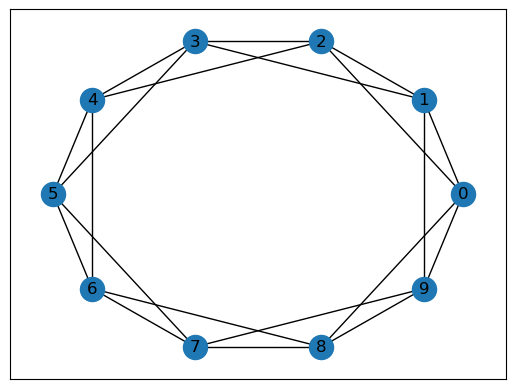

In [24]:
k = 4

for n in G.nodes:
    for i in range(1, k // 2 + 1):
        left  = (n-i) % N
        right = (n+i) % N 
        G.add_edge(n, left)
        G.add_edge(n, right)

nx.draw_networkx(G, with_labels=True, pos=nx.circular_layout(G))

### Rewire some edges

> For each edge $(u, v)$, with probability $p$, replace edge $(u, v)$ with (u, w) where $w$ is not a neighbor of $u$.

For this step, we make use of set arithmetic in order to generate a list of nodes that are not neighbors of $u$, and `random.choice` to select $w$ at random from that set of "not neighbors."

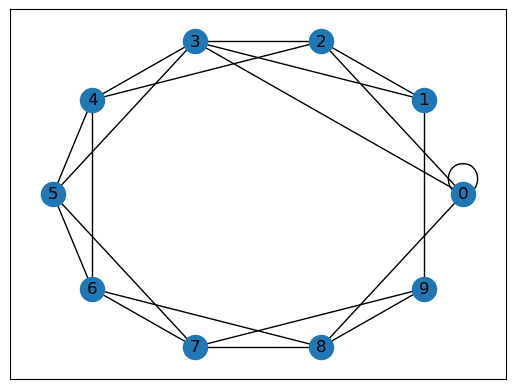

In [25]:
p = 0.1

for u, v in list(G.edges):
    if random.random() < p:
        not_neighbors = set(G.nodes) - set(G.neighbors(u))
        w = random.choice(list(not_neighbors))
        G.remove_edge(u, v)
        G.add_edge(u, w)

nx.draw_networkx(G, with_labels=True, pos=nx.circular_layout(G))

### Watts-Strogatz Small-World Model

We can put this together to write a basic function for the small-world model:

In [26]:
def watts_strogatz_graph(N, k, p):
    # 1. Create a ring of N nodes
    G = nx.cycle_graph(N)

    # 2. Connect each node n to k nearest neighbors
    #    [n-(k//2), ... , n-1, n+1, ... , n+(k//2)]
    for n in G.nodes:
        for i in range(1, k // 2 + 1):
            left  = (n-i) % N
            right = (n+i) % N 
            G.add_edge(n, left)
            G.add_edge(n, right)
    
    # 3. Rewire edges with probability p
    for u, v in list(G.edges):
        if random.random() < p:
            not_neighbors = set(G.nodes) - set(G.neighbors(u)) - {u}
            w = random.choice(list(not_neighbors))
            G.remove_edge(u, v)
            G.add_edge(u, w)

    return G

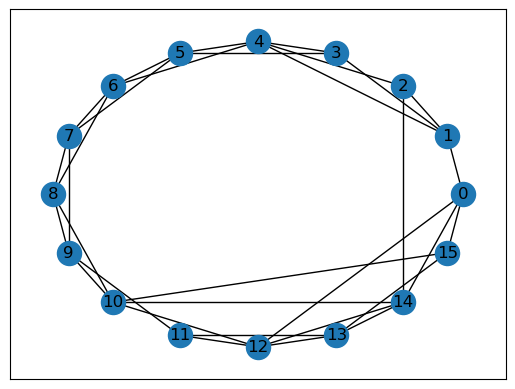

In [27]:
G = watts_strogatz_graph(16, 4, 0.2)
nx.draw_networkx(G, with_labels=True, pos=nx.circular_layout(G))

### NetworkX function

NetworkX has a function for this model: [watts_strogatz_graph()](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.random_graphs.watts_strogatz_graph.html).

# Preferential Attachment Model

The Barabási-Albert preferential attachment model has two parameters: the number of nodes $N$, and the number of links added at each step $m$. Given these parameters, the algorithm is as follows:

1. Start with a clique of $m + 1$ nodes.
2. Select $m$ different nodes at random, weighted by their degree.
3. Add a new node $i$ and link it with the $m$ nodes from the previous step.
4. Repeat 2-3 until there are N nodes in the graph.

The code for this is thus straightforward, with one possible exception: for step 3, we need to generate a *degree sequence* to weight the random selection. If we have a graph `G`, we can generate such a degree sequence with a list comprehension as follows:

[4, 1, 1, 1, 1]


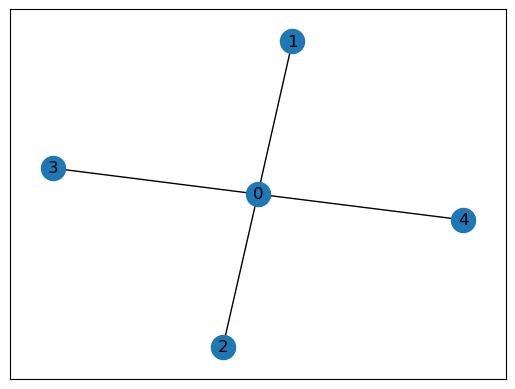

In [28]:
G = nx.star_graph(4)
degrees = [G.degree(n) for n in G.nodes]

print(degrees)
nx.draw_networkx(G, with_labels=True)

Note that the degree sequence is output in the same order as the nodes, such that the node at index $i$ in that list has the degree at index $i$ of the corresponding degree sequence. With this, we can write a function for the BA preferential attachment model:

In [29]:
def barabasi_albert_graph(N, m):
    # 1. Start with a clique of m+1 nodes
    G = nx.complete_graph(m + 1)
    for i in range(G.number_of_nodes(), N):
        # 2. Select m different nodes at random, weighted by their degree.
        new_neighbors = []
        possible_neighbors = list(G.nodes)
        for _ in range(m):
            degrees = [G.degree(n) for n in possible_neighbors]
            j = random.choices(possible_neighbors, degrees)[0]
            new_neighbors.append(j)
            possible_neighbors.remove(j)
        
        # 3. Add a new node i and link it with the m nodes from the previous step.
        for j in new_neighbors:
            G.add_edge(i, j)

    return G

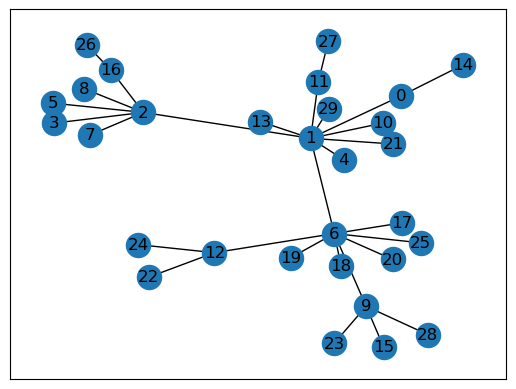

In [30]:
G = barabasi_albert_graph(30, 1)
nx.draw_networkx(G)

One might wonder why, in the previous code for `preferential_attachment_graph`, we didn't just write step 2 as

    new_neighbors = random.choices(G.nodes, degrees, k=m)
    
The issue here is that when one specifies $k > 1$ for `random.choices`, the selection is made with replacement, *i.e.* the same node can be selected from the list multiple times. The more complicated code is necessary so that we choose $m$ different nodes to join with node $i$.

### NetworkX function

As with all of these graph models, NetworkX has a function to generate a BA model: [barabasi_albert_graph()](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.random_graphs.barabasi_albert_graph.html).

### Exercise

#### For each of the previous models, using the networkx library, create networks with size 1000, trying different parameters for each model, and measuring the AVL, CC and the degree distribution